5/26/2021
1. Check the timestamps of p2c1 and p2c2 (will be fixed by Will) done
2. read all 6 cameras (done)
3. read June data with 3 RAV4's

Current pipeline:
1. preprocess
    a. 
    preprocess_multi_camera
2. rectify
3. postprocess
    extend prediction
    add-> transform back to image
    
4. visualize on the camera video!
    dissect it to seperate cameras
    plot for each camera

In [148]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pathlib
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA

In [149]:
# read all cameras into one df
import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4')
tform_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021/i24-roadway-transforms-main/tform')

df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv"):
            file_name = data_path.joinpath(file)
            camera_id = utils.find_camera_name(file)
            print('*** Reading ',camera_id,'...')
            df1 = utils.preprocess(file_name, tform_path)
            df1 = df1.assign(camera=camera_id)
            df = pd.concat([df, df1])
    break
# # MUST SORT!!! OTHERWISE DIRECTION WILL BE WRONG
df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)            
print('sorted.')


*** Reading  p1c2 ...
Reading data...
212
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:117: RuntimeWarning: invalid value encountered in greater
  outliers =	np.logical_or(abs(w1 - m) > 2 * s,abs(w2 - m) > 2 * s)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:127: RuntimeWarning: invalid value encountered in greater
  outliers =	np.logical_or(abs(l1 - m) > 2 * s,abs(l2 - m) > 2 * s)


filter width length: 212
Interpret missing timestamps...
Get the longest continuous frame chuck...
*** Reading  p1c3 ...
Reading data...
182
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:114: RuntimeWarning: Mean of empty slice
  m = np.nanmean([w1,w2])
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:124: RuntimeWarning: Mean of empty slice
  m = np.nanmean([l1,l2])


filter width length: 182
Interpret missing timestamps...
Get the longest continuous frame chuck...
*** Reading  p1c4 ...
Reading data...
151
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
filter width length: 151
Interpret missing timestamps...
Get the longest continuous frame chuck...
*** Reading  p1c5 ...
Reading data...
197
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
filter width length: 197
Interpret missing timestamps...
Get the longest continuous frame chuck...
*** Reading  p1c6 ...
Reading data...
209
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
filter width length: 209
Interpret missing timestamps...
Get the longest continuous frame chuck...
sorted.


In [69]:
# read & rectify each camera df individually
import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4/')
tform_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021/i24-roadway-transforms-main/tform')

# df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv") and file.startswith('p1c6'):
            
            # ... reading ...
            file_name = data_path.joinpath(file)
            camera_id = utils.find_camera_name(file)
            print('reading ',camera_id,'...')
            
            # ... preprocessing ...
            df = utils.preprocess(file_name, tform_path)
            df = df.assign(camera=camera_id)
            df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)
        
            # ... rectifying ...
            df = opt.rectify(df)
            
            # ... post processing ...
            dfpp = utils.post_process(df)
            dfpp_img = utils.road_to_img(dfpp, tform_path)
            
            # ... saving ...
            new_name = 'rectified_' + camera_id +'.csv'
            dfpp_img.to_csv(new_name)
    break

reading  p1c6 ...
Reading data...
209
Transform from image to road...
Deleting unrelavent columns...
Get x direction...
Naive filter...
after direction=0 filter:  206
after filtering short tracks:  189


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:117: RuntimeWarning: invalid value encountered in greater
  outliers =	np.logical_or(abs(w1 - m) > 2 * s,abs(w2 - m) > 2 * s)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:127: RuntimeWarning: invalid value encountered in greater
  outliers =	np.logical_or(abs(l1 - m) > 2 * s,abs(l2 - m) > 2 * s)


filter width length: 189
Interpret missing timestamps...
Get the longest continuous frame chuck...


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


No handles with labels found to put in legend.


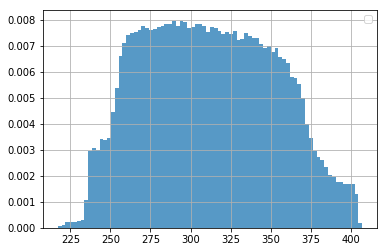

In [49]:
n, bins, patches = plt.hist(dfpp_img['fbr_x'][~np.isnan(dfpp_img['fbr_x'])], bins = 80, density=True, alpha=0.75)
# plt.xlim([-1000,8000])
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# select only one measurement from mutliple cameras per frame per ID
df = utils.preprocess_multi_camera(df)

100%|██████████████████████████████████████████████████████████████████████████████| 1797/1797 [00:18<00:00, 97.80it/s]


Get the longest continuous frame chuck...


In [4]:
import utils_optimization as opt
importlib.reload(opt)
dfre = opt.rectify(df) # parallel, batch method

100%|██████████████████████████████████████████████████████████████████████████████| 1215/1215 [05:45<00:00,  3.52it/s]


ID: 3120 # frames: 120 # cameras: 2


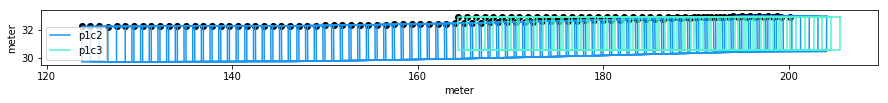

In [38]:
utils.plot_track_df_camera(pd.concat([box1,box2]), tform_path)

30120 1.264581826296469


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


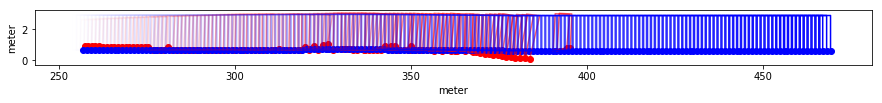

Text(0,0.5,'Position (m)')

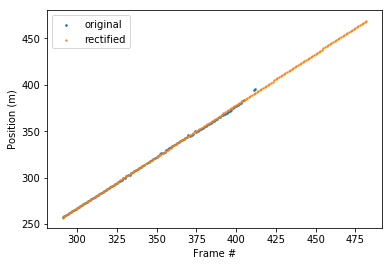

In [72]:
# debug misaligned footprints on videos
import utils
importlib.reload(utils)
import utils_optimization as opt
importlib.reload(opt)

car = df1[df1['ID']==30120]
car1 = car.copy() # original df
car = opt.rectify_single_camera(car)
# car = utils.post_process(car)
utils.plot_track_compare(car1, car)

x = car1['Frame #'].values
y = car1['fbr_x'].values
plt.scatter(x,y, s=2.5,label='original')

xre = car['Frame #'].values
yre = car['fbr_x'].values
plt.scatter(xre,yre, s=1.5,label='rectified')

plt.legend()
plt.xlabel('Frame #')
plt.ylabel('Position (m)')


In [5]:
import utils
importlib.reload(utils)
import utils_optimization as opt
importlib.reload(opt)

dfrep = utils.post_process(dfre) 

cap width at 2.59m...


In [194]:
dfrep_img.to_csv('rectified_all_img_re.csv')

In [9]:
# save file to individual cameras

import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4')
groups = dfrep_img.groupby('camera_post')
for camera_id, group in groups:
    file_name = 'rectified_'+camera_id+'.csv'
    group.to_csv(data_path.joinpath('rectified/uncorrected_all/' + file_name))
        


In [157]:
# visualize footprint on the camera video

import plot_rectified_objects
importlib.reload(plot_rectified_objects)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4')
video = str(data_path.joinpath('p1c3_00000_track_outputs_corrected_3D.csv_3D.mp4'))
label_file = str(data_path.joinpath('uncorrected/p1c3_00000_track_outputs_unique_3D.csv')) 
# label_file = str(data_path.joinpath('rectified/p1_all/rectified_p1c3.csv')) 
# label_file = str(data_path.joinpath('rectified/uncorrected_individual/rectified_p1c3_uncorrected.csv'))
# label_file = str(data_path.joinpath('rectified/uncorrected_all/rectified_p1c3.csv'))
plot_rectified_objects.plot_rectified_objects(video,label_file,frame_rate = 10)


IndexError: list index out of range

In [ ]:
start = time.time()
Yre = opt.receding_horizon_opt(Y,timestamps,w,l,n,lam1,lam2,lam3,lam4,lam5,PH,IH)
end = time.time()
times_200[sec] = end-start
error_200[sec] = LA.norm(Y-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
print('time: ',times_200[sec],'error: ',error_200[sec])

In [190]:
dfrep.to_csv('rectified_p1c4_rem_overlap.csv')

1215 unique cars
110


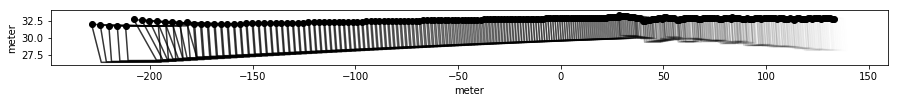

110 22.48163410339677


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


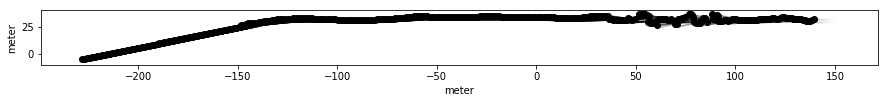

120


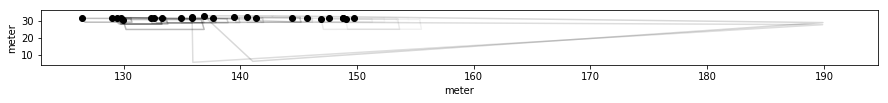

120 41.64700451883768


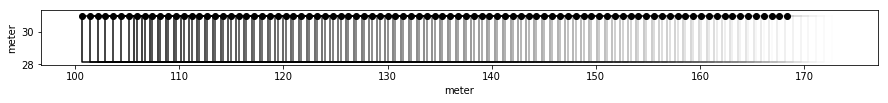

130


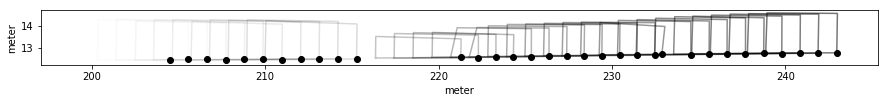

130 0.7675570807473867


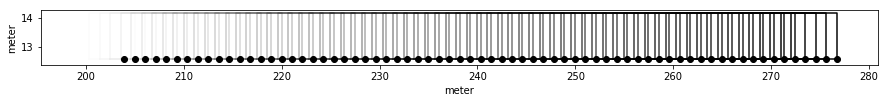

150


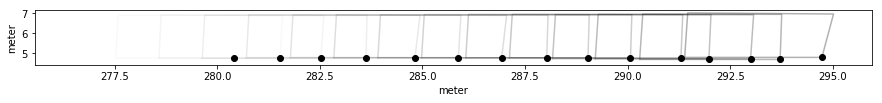

150 0.26659942986362223


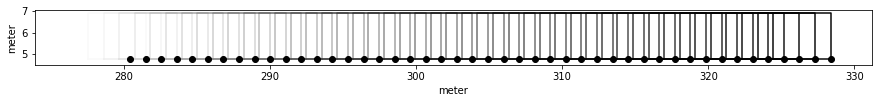

160


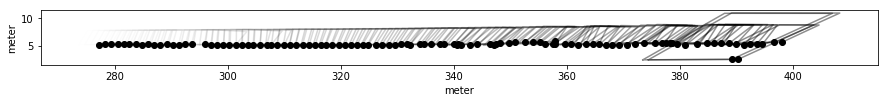

160 3.2924384579260315


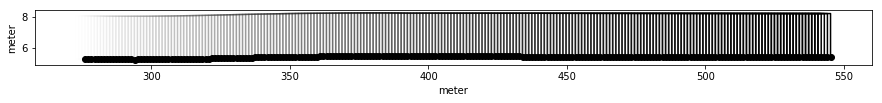

1110


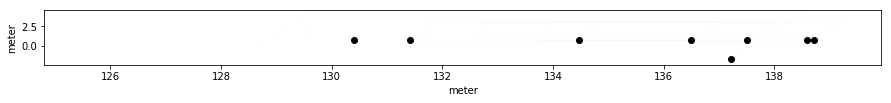

1110 1.7059793789838342


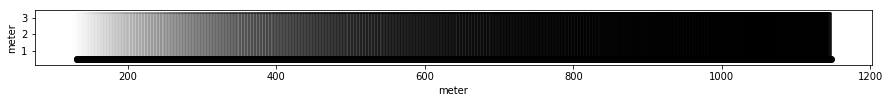

1120


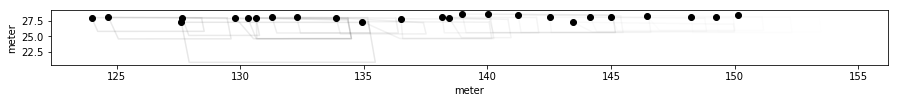

1120 6.813580443473975


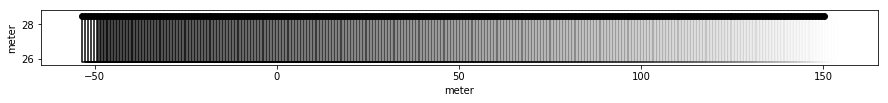

1130


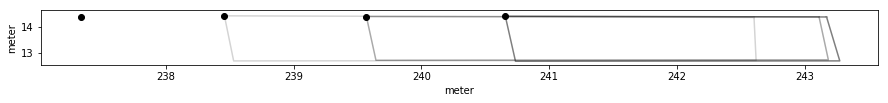

1130 10.258481737575723


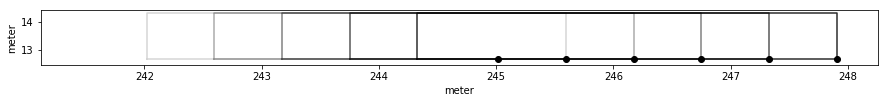

1140


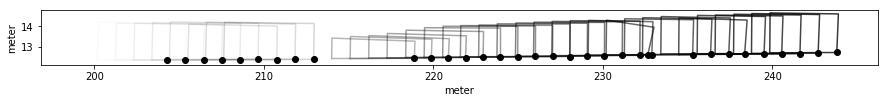

1140 0.8499349497790654


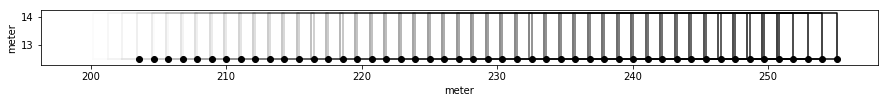

1160


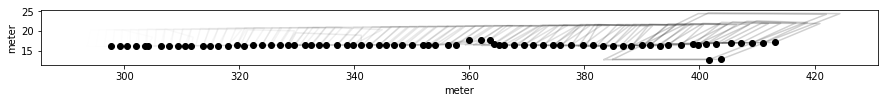

1160 9.295329443814216


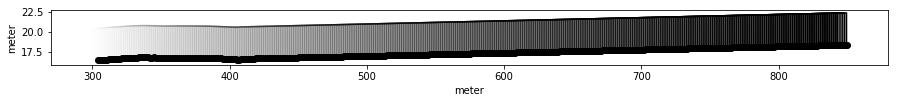

2110


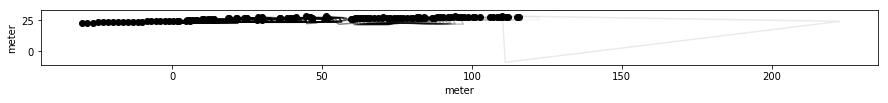

2110 6.455171135218491


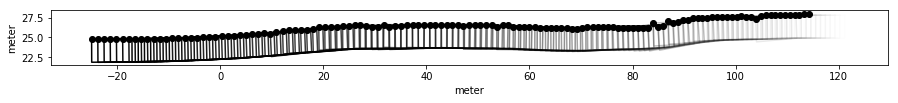

2120


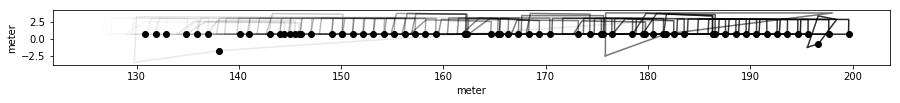

2120 2.3372397455557055


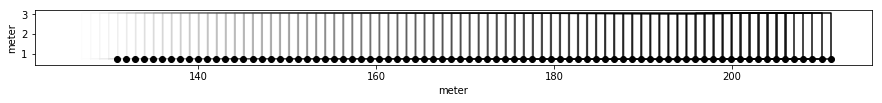

2130


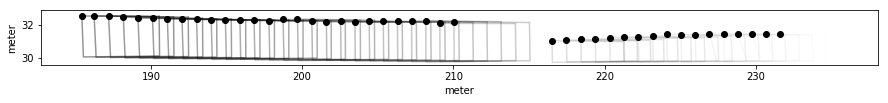

2130 0.6577435652106232


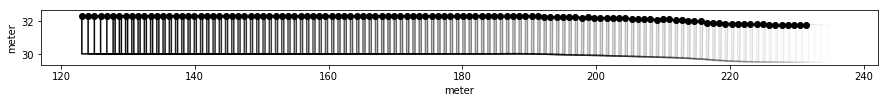

2140


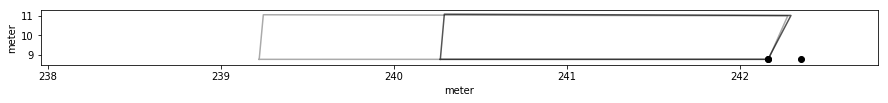

2140 1.1585809152090054


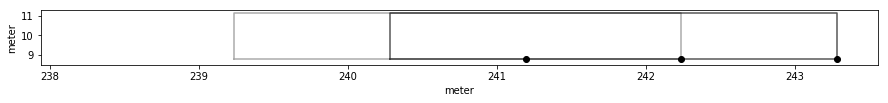

2150


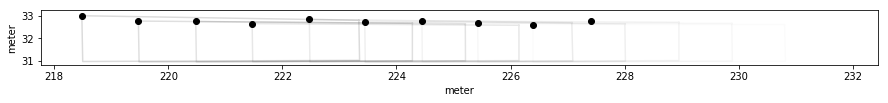

2150 0.24659338874913886


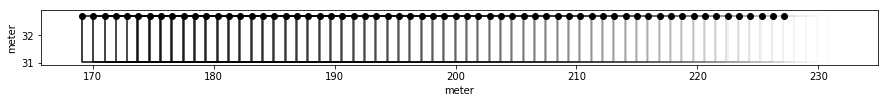

2160


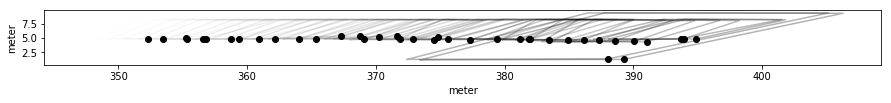

2160 5.973781352426276


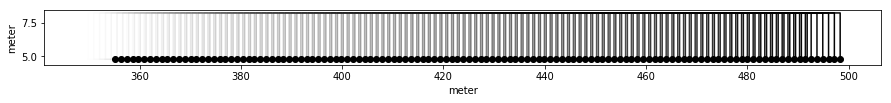

3110


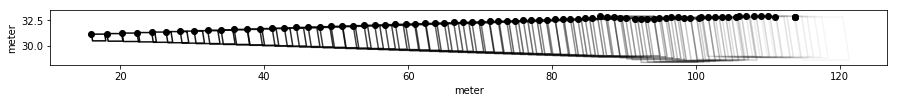

3110 7.406178886077583


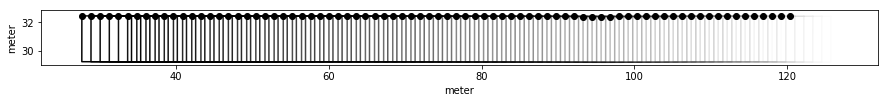

3120


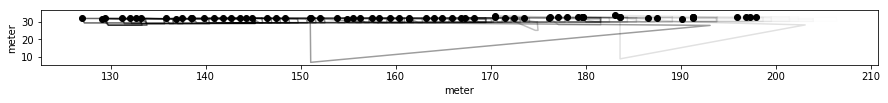

3120 2.849976108934796


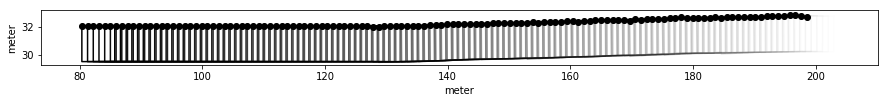

3130


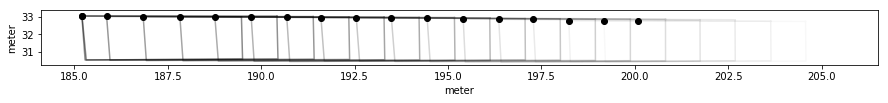

3130 0.23800636986485169


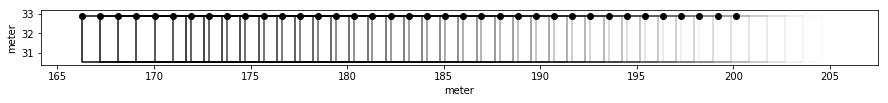

3140


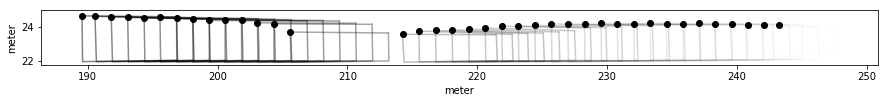

3140 1.9676305399644578


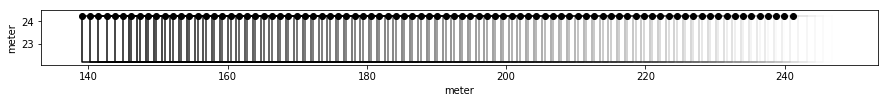

3150


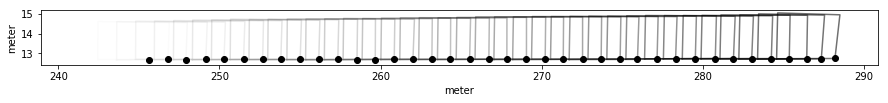

3150 0.1529773859640686


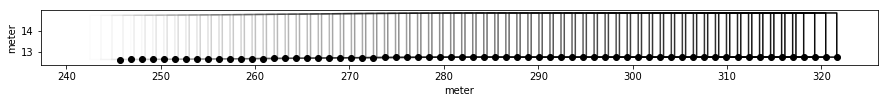

4110


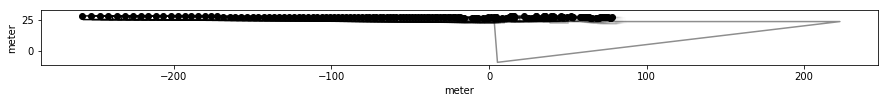

4110 28.9261349653425


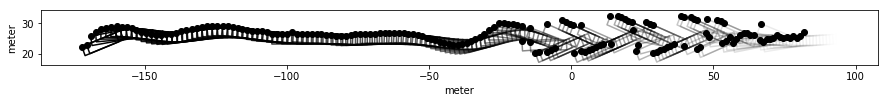

4130


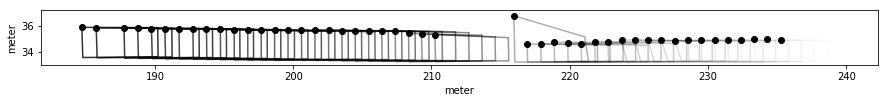

4130 0.73947178358029


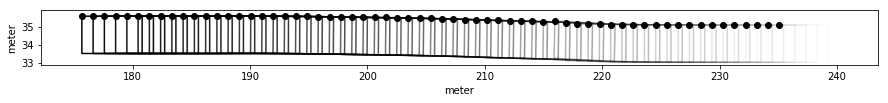

4150


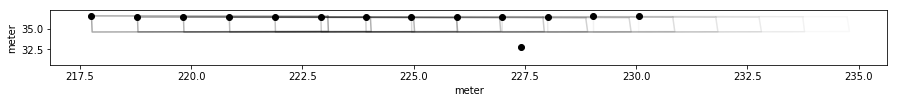

4150 1.47602042766501


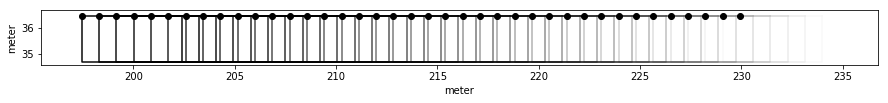

4160


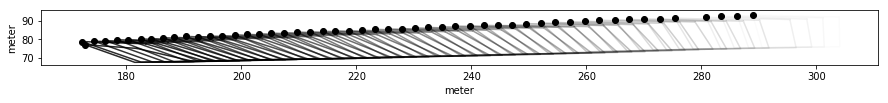

4160 57.069288280317835


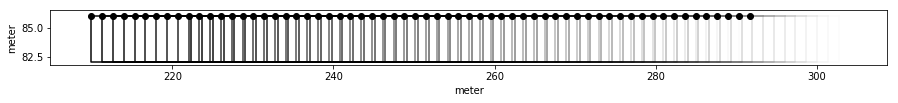

5120


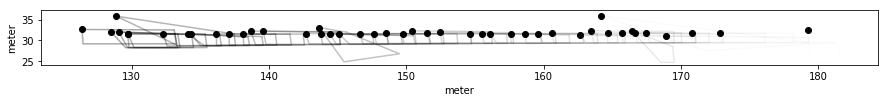

5120 1.9834864983746285


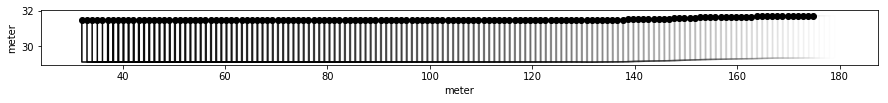

5140


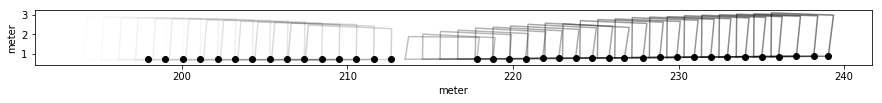

5140 0.7397063532835192


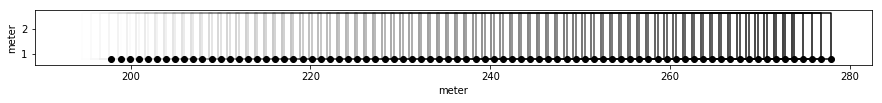

5160


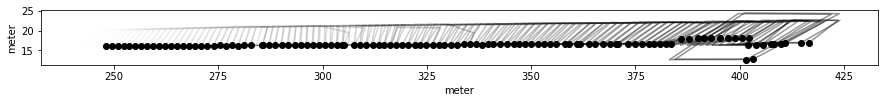

5160 5.421093666208697


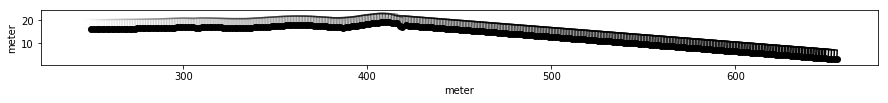

6110


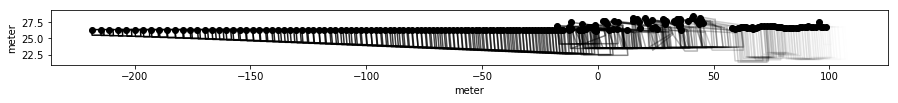

6110 19.741404609196593


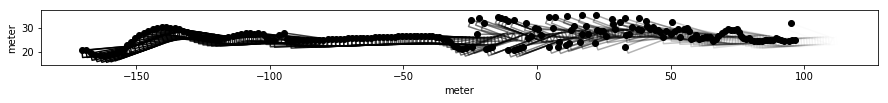

6130


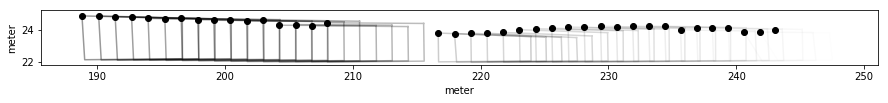

6130 0.906036222730207


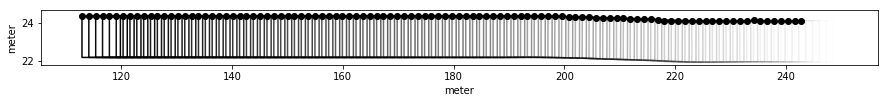

6140


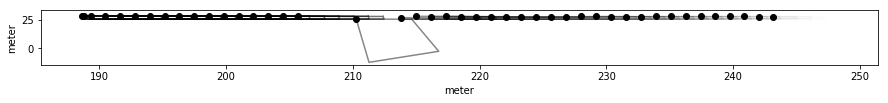

6140 2.130469970899492


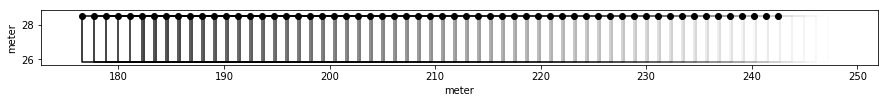

6150


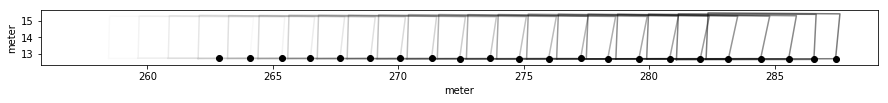

6150 0.3046535417528556


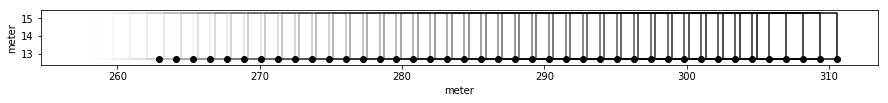

6160


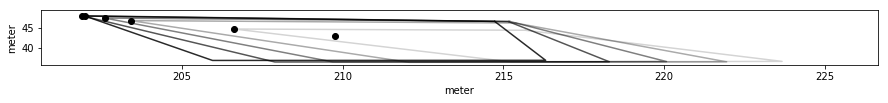

6160 10.15876365502743


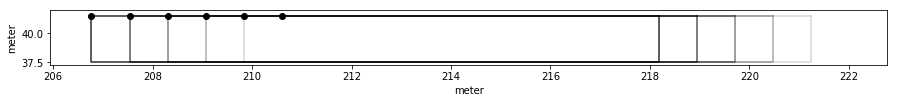

7110


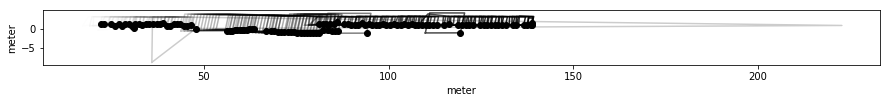

7110 5.087899859950412


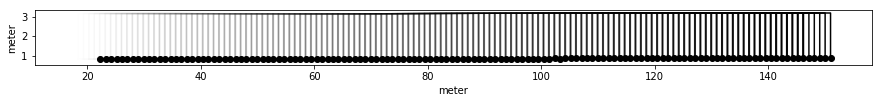

7140


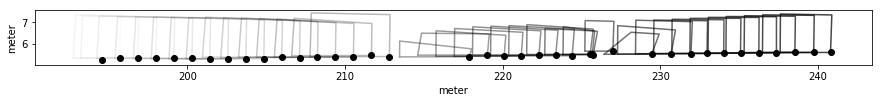

7140 1.0750168250289163


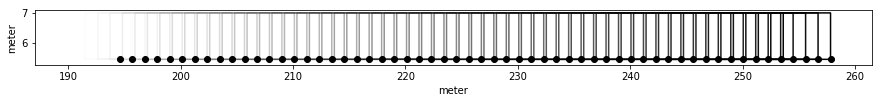

7150


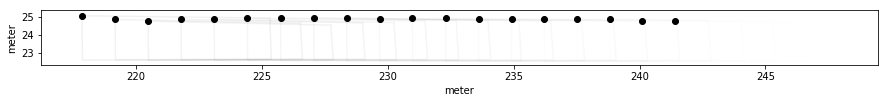

7150 0.5383562031448249


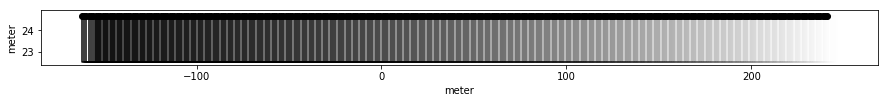

8110


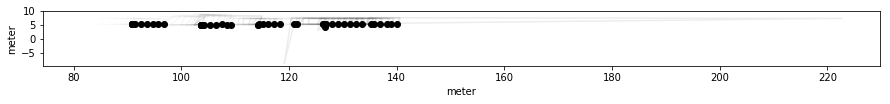

8110 5.6477825698527


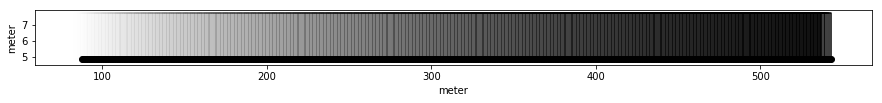

8140


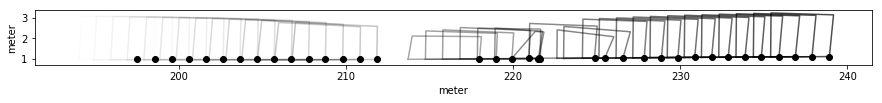

8140 0.8512261044948939


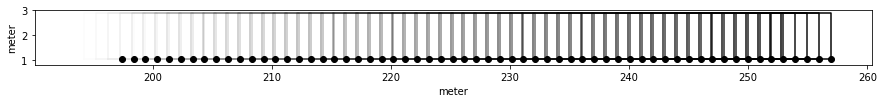

8160


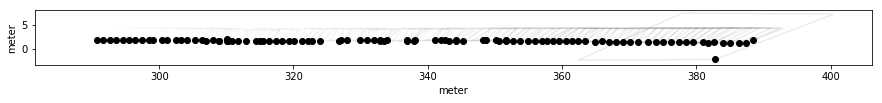

8160 6.514189135194972


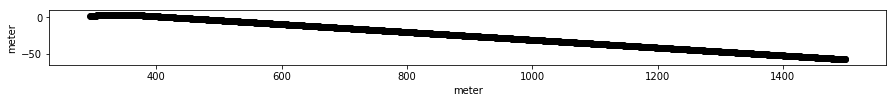

9110


KeyboardInterrupt: 

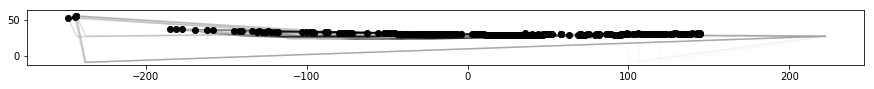

In [32]:
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)
from matplotlib.pyplot import cm
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
nc = 2 # number of different colors
print(nO,'unique cars')

for carid, car in groups:
    print(carid)
    utils.plot_track_df(car)
    car = opt.rectify_single_camera(car)
    utils.plot_track_df(car)

In [142]:
# get a sense of runtime vs. #frames total
import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)

# try a receding horizon approach
PH = 200 # optimize over Prediction Horizon frames
IH = 100 # implementation horizon

fps = 30
num_secs = np.linspace(1,300,20)
times_200 = np.zeros(len(num_secs))
error_200 = np.zeros(len(num_secs))

for sec in range(len(num_secs)):
    num_sec = num_secs[sec]
    # generate synthetic data
    n = int(num_sec*fps) # frames
    print(n)
    if (n<IH):
        times_100[sec] = 0
        error_100[sec] = 0
        continue
    timestamps, Y = opt.create_synth_data(n)
    notNan = ~np.isnan(np.sum(Y,axis=-1))

    w,l = opt.estimate_dimensions(Y[:100,:],timestamps[:100],lam1,lam2,lam3,lam4,lam5) # use some data to estimate vehicle dimensions
    print('estimated w:',w,'l:',l)

    start = time.time()
    Yre = opt.receding_horizon_opt(Y,timestamps,w,l,n,lam1,lam2,lam3,lam4,lam5,PH,IH)
    end = time.time()
    times_200[sec] = end-start
    error_200[sec] = LA.norm(Y-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
    print('time: ',times_200[sec],'error: ',error_200[sec])


30
502
estimated w: 1.998513212685446 l: 3.961215098851152
time:  9.371170043945312 error:  0.030917113236006624
974
estimated w: 2.0044665533127897 l: 3.9691512485512295
time:  19.342235326766968 error:  0.022269822404459322
1446
estimated w: 1.999101087196299 l: 3.992403622046191
time:  27.83709192276001 error:  0.017594596469392893
1918
estimated w: 1.9956281453811122 l: 4.018317052933087
time:  38.91985058784485 error:  0.015269792160901534
2390
estimated w: 2.001102993985751 l: 3.9795681120218704
time:  46.79075217247009 error:  0.013686046338037642
2862
estimated w: 2.014407703068054 l: 4.0475153169625555
time:  57.36873245239258 error:  0.01220661630240655
3334
estimated w: 2.024100282700977 l: 3.9462329132329406
time:  66.97627449035645 error:  0.011450558436908335
3806
estimated w: 2.0186203447417093 l: 4.0114144696839835
time:  75.59730505943298 error:  0.010662129480374812
4278
estimated w: 2.023154281197527 l: 3.9573287584302723
time:  85.68555068969727 error:  0.0100673340

Text(0.5,1,'error')

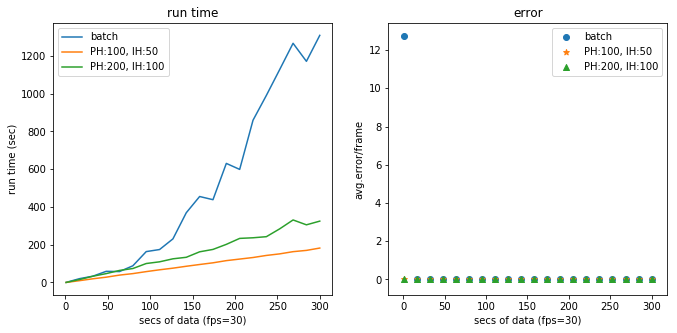

In [148]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,5))

ax1.plot(num_secs,times,label='batch')
ax1.plot(num_secs,times_100,label = 'PH:100, IH:50')
ax1.plot(num_secs,times_200,label = 'PH:200, IH:100')
ax1.legend()
ax1.set_xlabel('secs of data (fps=30)')
ax1.set_ylabel('run time (sec)')
ax1.set_title('run time')

ax2.scatter(num_secs,error,label='batch')
ax2.scatter(num_secs,error_100,marker='*',label = 'PH:100, IH:50')
ax2.scatter(num_secs,error_200,marker='^',label = 'PH:200, IH:100')
ax2.legend()
ax2.set_xlabel('secs of data (fps=30)')
ax2.set_ylabel('avg.error/frame')
ax2.set_title('error')

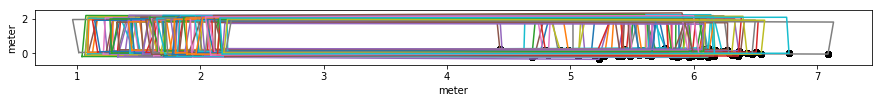

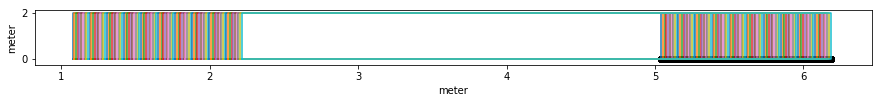

In [145]:
D = Y1[100:200,:]
fig, ax = plt.subplots(figsize=(15,1))
for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
plt.show()
D = Yre[100:200,:]
fig, ax = plt.subplots(figsize=(15,1))
for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
plt.show()

In [48]:
# check consistency of acceleration/theta for minibatches on synthetic data

import utils_optimization as opt
importlib.reload(opt)
import utils
importlib.reload(utils)

# receding horizon approach
PH = 100 # optimize over Prediction Horizon frames
IH = 50 # implementation horizon
fps = 30
num_sec = 20

# generate synthetic data
n = int(num_sec*fps) # frames

timestamps, Y = opt.create_synth_data(n)
notNan = ~np.isnan(np.sum(Y,axis=-1))

w,l = opt.estimate_dimensions(Y[:100,:],timestamps[:100]) # use some data to estimate vehicle dimensions
print('estimated w:',w,'l:',l)

start = time.time()
Yre,a_arr,x_arr,v_arr,theta_arr = opt.receding_horizon_opt(Y,timestamps,w,l,n,PH,IH)
end = time.time()

print('run time: ',end-start,'correction/frame: ',LA.norm(Y-Yre[notNan,:],'fro')/np.count_nonzero(notNan))


estimated w: 1.9705144884495036 l: 4.010601123440583
0 / 600
50 / 600
100 / 600
150 / 600
200 / 600
250 / 600
300 / 600
350 / 600
400 / 600
450 / 600
500 / 600
run time:  19.61164689064026 correction/frame:  0.026481489367053863


(600,)

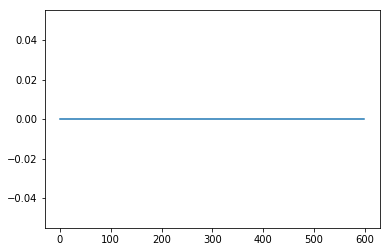

In [50]:
from matplotlib import cm
color=cm.rainbow(np.linspace(0,1,n))

for each car i
    plt.plot(xxx, color = color[i%n])
